In [50]:
!pip install -r Requirements.txt

In [51]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 

In [52]:
#Dataset import
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [53]:
#Show Preview Dataset
train.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Yes,7394-FKDNK,Female,0,Yes,No,9,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,89.45,853.1
1,No,0310-SUCIN,Female,0,Yes,No,71,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),84.80,6046.1
2,No,5074-FBGHB,Male,0,No,No,64,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),104.65,6889.8
3,Yes,7721-JXEAW,Male,0,Yes,No,59,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),41.05,2452.7
4,No,5934-TSSAU,Female,0,Yes,Yes,23,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),75.30,1702.9


In [54]:
#Counting Missing Values
missing_values_count = train.isnull().sum()
missing_values_count

Churn               0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [55]:
#DropNa
if test.isnull().values.any():
  test=test.dropna()

Essendo un valore univoco il costumer Id sicuramente non è collegato quindi lo elimino dal dataset

In [56]:
#Clean Dataset 
train=train.drop(axis=1, columns='customerID')
test=test.drop(axis=1, columns='customerID')
train

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Yes,Female,0,Yes,No,9,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,89.45,853.1
1,No,Female,0,Yes,No,71,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),84.80,6046.1
2,No,Male,0,No,No,64,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),104.65,6889.8
3,Yes,Male,0,Yes,No,59,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),41.05,2452.7
4,No,Female,0,Yes,Yes,23,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),75.30,1702.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4502,No,Female,0,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),82.65,5919.35
4503,Yes,Female,0,Yes,Yes,23,Yes,No,Fiber optic,No,Yes,Yes,Yes,No,No,Month-to-month,No,Electronic check,83.80,1900.25
4504,No,Male,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,19.10,53.05
4505,No,Female,0,Yes,Yes,5,No,No phone service,DSL,No,Yes,No,Yes,No,No,Month-to-month,No,Electronic check,34.25,163.55


Visionando alcuni valori di TotalCharges noto che al posto del valore è presente il carattere spazio

In [57]:
train[train['TotalCharges']==' ']

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
294,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,
550,No,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
1009,No,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
1654,No,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,
2087,No,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,
3381,No,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,
3693,No,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
3842,No,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,


Decido di sostituire quindi al posto del valore ' ' il valore MonthlyCharges moltiplicato per la la durata del contratto 

In [58]:
#Add Values When TotalCharges = ' ' in test and train
test.TotalCharges=test.TotalCharges.where((test.TotalCharges!=' ') | (test.Contract!='One year'),test.MonthlyCharges*12 )
test.TotalCharges=test.TotalCharges.where((test.TotalCharges!=' ') | (test.Contract!='Two year'),test.MonthlyCharges*24 )
test.TotalCharges=test.TotalCharges.where((test.TotalCharges!=' ') | (test.Contract!='Month-to-month'),test.MonthlyCharges )

train.TotalCharges=train.TotalCharges.where((train.TotalCharges!=' ') | (train.Contract!='One year'),train.MonthlyCharges*12 )
train.TotalCharges=train.TotalCharges.where((train.TotalCharges!=' ') | (train.Contract!='Two year'),train.MonthlyCharges*24 )
train.TotalCharges=train.TotalCharges.where((train.TotalCharges!=' ') | (train.Contract!='Month-to-month'),train.MonthlyCharges) 
 
train['TotalCharges'] = pd.to_numeric(train['TotalCharges'])
test['TotalCharges'] = pd.to_numeric(test['TotalCharges'])

No     3310
Yes    1197
Name: Churn, dtype: int64


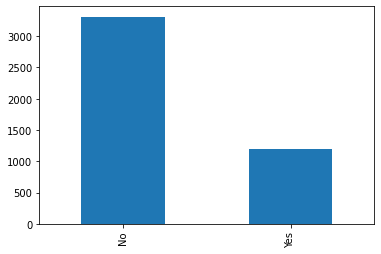

In [59]:
#Target values distribution
print(train.Churn.value_counts())
p=train.Churn.value_counts().plot(kind="bar")

In [60]:
#Feature to encode
le = preprocessing.LabelEncoder()
#Feature Encoding
for l in train:
  if ((l!='MonthlyCharges')|(l!='TotalCharges')):
    train[l]=le.fit_transform(train[l])
    test[l]=le.fit_transform(test[l])

#Label Encoding
le = preprocessing.LabelEncoder()
test = test.apply(le.fit_transform)
train = train.apply(le.fit_transform)

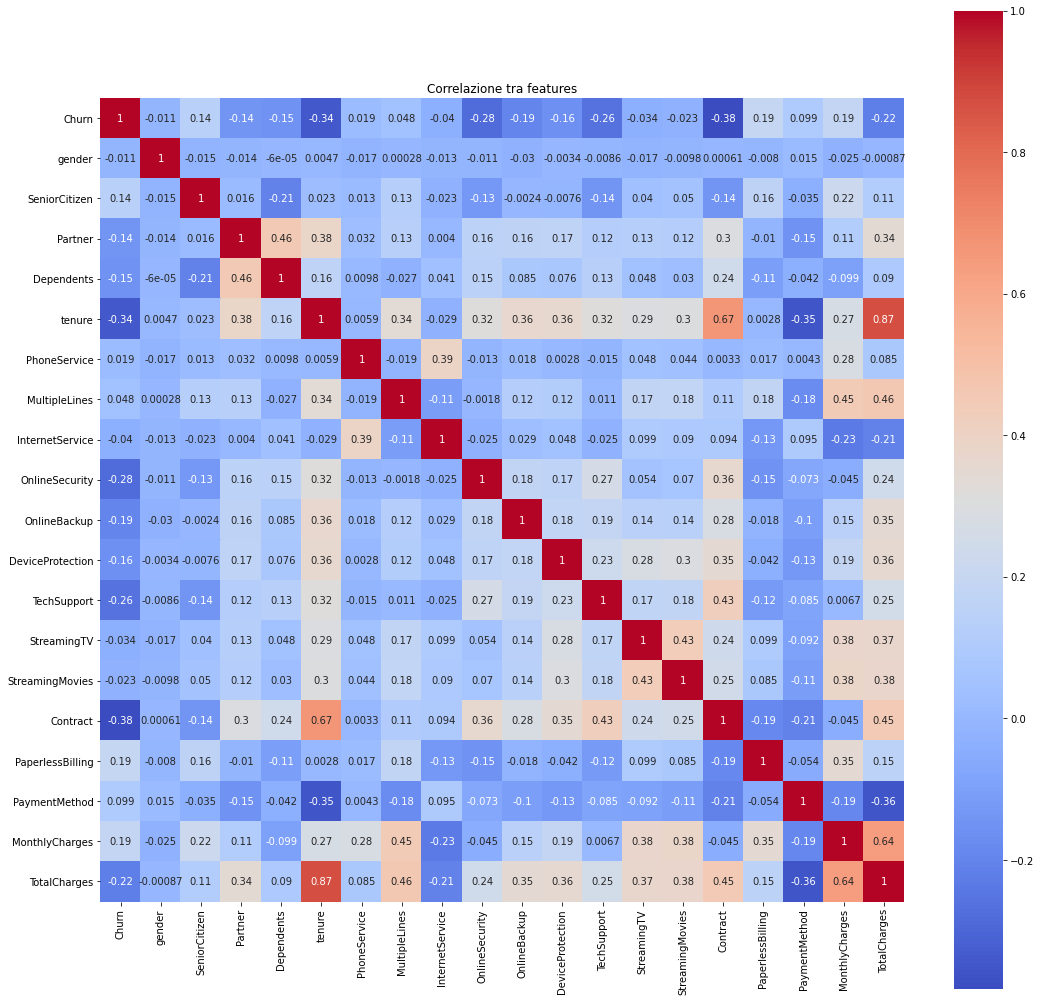

In [61]:
#Correlation
correlation = train.corr()
plt.figure(figsize=(18,18))
sns.heatmap(correlation, vmax=1,  cmap='coolwarm', square=True,annot=True)
plt.title('Correlazione tra features')
plt.show()

Noto che ci sono molte feature con bassa correlazione rispetto a Churn quindi rimuovo tutte le features con modulo della correlazione minore di 0.2

In [62]:
for l in train.columns :
  if abs(correlation['Churn'][l])<0.2 :
     train=train.drop(l, axis=1)
     test=test.drop(l, axis=1)

In [63]:
trainY=train['Churn']
testY=test['Churn']
trainX=train.drop('Churn', axis=1)
testX=test.drop('Churn', axis=1)

In [64]:
#Scaling (Standardization)
sc= preprocessing.StandardScaler()
trainX = pd.DataFrame(sc.fit_transform(trainX))
testX = pd.DataFrame(sc.fit_transform(testX))

In [65]:
#Model training and score
model = DecisionTreeClassifier(max_leaf_nodes=6,random_state=8, criterion='entropy')
model.fit(trainX, trainY)
prediction = model.predict(testX)
print('Accuracy:', accuracy_score(testY, prediction))

Accuracy: 0.782608695652174


Text(0.5, 15.0, 'Predicted label')

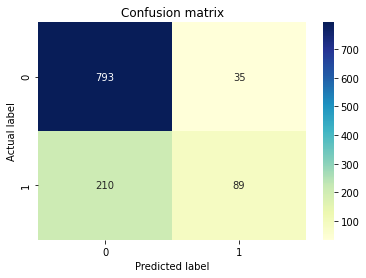

In [66]:
predY = model.predict(testX)

cnf_matrix = metrics.confusion_matrix(testY, predY)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Ci sono molti falsi negativi poichè sono presenti pochi esempi relativi al caso positivo, quindi il modello non generalizza bene.